In [1]:
"""
This project was developed by Peter Chen, Rocky Duan, Pieter Abbeel for the Berkeley Deep RL Bootcamp, August 2017.
Bootcamp website with slides and lecture videos: https://sites.google.com/view/deep-rl-bootcamp/.

Code adapted from Stanford CS231N materials: http://cs231n.stanford.edu/
"""


# note to properly run this lab, you should execute all code blocks sequentially
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions

from collections import namedtuple, defaultdict, deque

import numpy as np

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

## Introduction to Chainer

Chainer can be understood as Numpy plus the ability to record the computation graph of numerical operations to enable Automatic Differentiation. (Chainer actually also offers many other things; for example, a Numpy equivalent library that runs on GPU, but we will ignore them for now)

Let's illustrate how Chainer works by a simple 1D regression task.

Suppose we have observations from the following model $y = w x + b + \epsilon$ where $\epsilon \sim \mathcal{N}(0, 0.1)$ and the task is to estimate the linear model parameters $w, b$ from data.

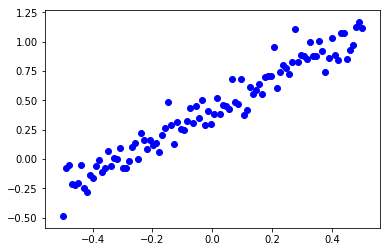

In [2]:
# first generate some observations
true_a = 1.3
true_b = 0.4
data_x = (np.arange(100) / 99.0 - .5).astype(np.float32) # Chainer assumes all the cpu computation is done in float32
data_y = (data_x * true_a + true_b + np.random.randn(*data_x.shape) * 0.1).astype(np.float32)
_ = plt.scatter(data_x, data_y, c='b')

Chainer provides an abstraction called `Link` that describe some computation and keeps track of parameters for it. For instance, a `Linear` link describes a linear map on input and keeps track of `w` and bias `b`.

In [3]:
model = L.Linear(in_size=1, out_size=1) # input is 1D data and output is also 1D data

# Chainer will randomly initialize `w` and `b` for us.
# we can take a look at their values
print("w:", model.W)
print("b:", model.b)

# model.W and model.b have type `chainer.Variable`, 
#   which is a wrapper around Numpy array
assert isinstance(model.W, chainer.Variable)

# operations that involve `chainer.Variable` will produce
#   `chainer.Variable` and this records the computation graph
var_result = model.W + 123 # some random computation
print("Operations on chainer.Variable: %s, type: %s" % (var_result, type(var_result)))

# the underlying numpy array can be accessed by `data` attribute
print("numpy arrays:", model.W.data, var_result.data)

w: variable W([[ 0.24163038]])
b: variable b([ 0.])
Operations on chainer.Variable: variable([[ 123.24163055]]), type: <class 'chainer.variable.Variable'>
numpy arrays: [[ 0.24163038]] [[ 123.24163055]]


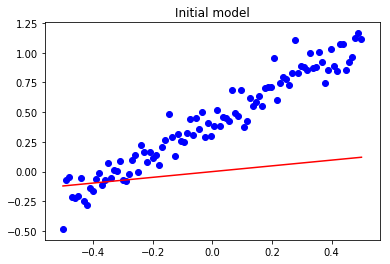

In [4]:
# A chainer link is a callable object. calling it performs the
#   forward computation. (in this case, it performs Wx + b)
model_y = model(data_x[:, None]) # chainer's link usually assumes input is [Batch Size, Input Dimension]
# `model_y` is a chainer variable so we use `.data` to access its numpy array for plotting

# we can plot the model's current fit in red. it should be terrible because we haven't trained it yet
_ = plt.plot(data_x, model_y.data[:,0], c='r')
_ = plt.scatter(data_x, data_y, c='b')
_ = plt.title("Initial model")

In [8]:
# now let's walk through how to perform forward computation
#  and use AD to get gradients

# first we clear the gradients that are stored in the model
model.cleargrads()
# as we have seen we can perform forward computation by calling the link
model_y = model(data_x[:, None])

# remember that `model_y` is a chainer variable. to operate on chainer variable
#    we will use functions from chainer.functions to operate on those objects.
loss = F.mean(F.square(model_y - data_y[:, None]))
# `loss` is a scalar chainer variable
assert isinstance(loss, chainer.Variable)
print("loss", loss)
# calculating gradients d loss /d params is as simple as
loss.backward()

# we can inspect the gradient of loss with respect to W
print("dloss/dW", model.W.grad)

loss variable(0.29302483797073364)
dloss/dW [[-0.18735619]]


Now that we know how to calculate gradients, we can code up a simple loop to perform gradient descent to train this model:

(Hint: if you run into weird problems, maybe the state has been messed up and you can try re-runing all the code blocks from the beginning)

Itr 0 loss: variable(0.2238878607749939)
Itr 25 loss: variable(0.10639268904924393)
Itr 50 loss: variable(0.06206352263689041)
Itr 75 loss: variable(0.04450489580631256)
Itr 100 loss: variable(0.03681071847677231)
Itr 125 loss: variable(0.032814912497997284)
Itr 150 loss: variable(0.030263304710388184)
Itr 175 loss: variable(0.028327085077762604)
Itr 200 loss: variable(0.02669709362089634)
Itr 225 loss: variable(0.025254065170884132)
Itr 250 loss: variable(0.0239484254270792)
Itr 275 loss: variable(0.022756442427635193)
Itr 300 loss: variable(0.02166430465877056)
Itr 325 loss: variable(0.02066218852996826)
Itr 350 loss: variable(0.019742168486118317)
Itr 375 loss: variable(0.018897321075201035)
Itr 400 loss: variable(0.018121441826224327)
Itr 425 loss: variable(0.017408858984708786)
Itr 450 loss: variable(0.016754407435655594)
Itr 475 loss: variable(0.016153352335095406)
Itr 500 loss: variable(0.015601318329572678)
Itr 525 loss: variable(0.015094303525984287)
Itr 550 loss: variable(0.0

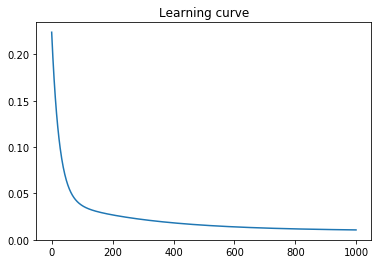

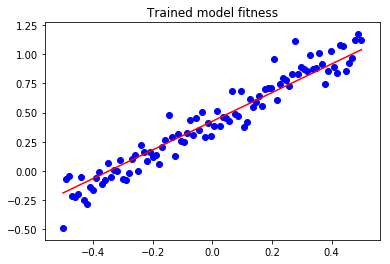

In [11]:
# now we can perform gradient descent to improve this model
model = L.Linear(in_size=1, out_size=1)
losses = []

lr = 0.01

for i in range(1000):
    model.cleargrads()
    loss = F.mean(F.square(model(data_x[:, None]) - data_y[:, None]))
    losses.append(float(loss.data))
    ## *** YOUR CODE HERE TO PERFORM GRADIENT DESCENT ***
    ## Hint: you could access gradients with model.W.grad, model.b.grad
    ## Hint2: you could write data into a parameter with model.W.data[:] = some_numpy_array
    ## Hint3: if your model doesn't learn, remember to try different learning rates
    loss.backward()
    
    model.W.data[:] -= lr*model.W.grad
    model.b.data[:] -= lr*model.b.grad
    
    if i % 25 == 0:
        print("Itr", i, "loss:", loss)
plt.plot(np.array(losses))
plt.title("Learning curve")
plt.figure()
plt.plot(data_x, model(data_x[:, None])[:,0].data, c='r')
plt.scatter(data_x, data_y, c='b')
_ = plt.title("Trained model fitness")


## Train your first deep model

Now we have learned the basics of Chainer. We can use it to train a deep model to classify MNIST digits. We will train a model on the MNIST dataset because the dataset is small.

First we load the data and see what the images look like:

train[i][0] is the ith image that's flattened, and has shape: (784,)
train[i][1] is the ith image's label, such as: 3


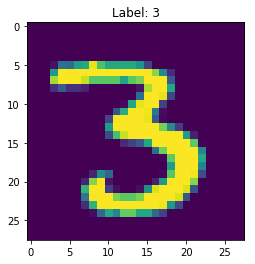

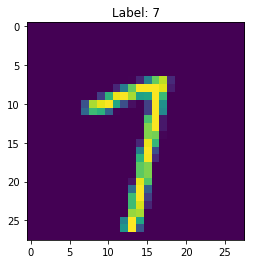

In [12]:
train, test = chainer.datasets.get_mnist()
# use train[data_point_index] to access data
print("train[i][0] is the ith image that's flattened, and has shape:", train[12][0].shape)
print("train[i][1] is the ith image's label, such as:", train[12][1])
# here we visualize two of them
plt.imshow(train[12][0].reshape([28, 28,]))
plt.title("Label: %s" % train[12][1])
plt.figure()
plt.imshow(train[42][0].reshape([28, 28,]))
_ = plt.title("Label: %s" % train[42][1])

Next we will provide some boilerplate code and train a linear classifier as an example:

In [13]:
def run(model, batchsize=16, num_epochs=2):
    
    optimizer = chainer.optimizers.Adam() # we will use chainer's Adam implementation instead of writing our own gradient based optimization
    optimizer.setup(model)
    
    stats = defaultdict(lambda: deque(maxlen=25))
    for epoch in range(num_epochs):
        train_iter = chainer.iterators.SerialIterator(train, batchsize, repeat=False, shuffle=True)
        test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
        
        for itr, batch in enumerate(train_iter):
            xs = np.concatenate([datum[0][None, :] for datum in batch])
            ys = np.array([datum[1] for datum in batch])

            logits = model(xs)

            loss = F.softmax_cross_entropy(logits, ys)
            model.cleargrads()
            loss.backward()
            optimizer.update()
            
            # calculate stats
            stats["loss"].append(float(loss.data))
            stats["accuracy"].append(float((logits.data.argmax(1) == ys).sum() / batchsize))
            if itr % 300 == 0:
                print("; ".join("%s: %s" % (k, np.mean(vs)) for k, vs in stats.items()))

# try a simple linear model
run(L.Linear(None, 10))

accuracy: 0.0; loss: 2.44795298576
accuracy: 0.865; loss: 0.608150519133
accuracy: 0.875; loss: 0.476190109253
accuracy: 0.895; loss: 0.384984177351
accuracy: 0.895; loss: 0.370705761313
accuracy: 0.9025; loss: 0.366878062487
accuracy: 0.8925; loss: 0.349658022225
accuracy: 0.885; loss: 0.348445186913
accuracy: 0.905; loss: 0.367749609947
accuracy: 0.915; loss: 0.313951142132
accuracy: 0.9325; loss: 0.235615383387
accuracy: 0.9325; loss: 0.304321626425
accuracy: 0.9175; loss: 0.307206556499
accuracy: 0.895; loss: 0.340669887066
accuracy: 0.9025; loss: 0.380669412017
accuracy: 0.9225; loss: 0.294745050371
accuracy: 0.9125; loss: 0.354209874272
accuracy: 0.9375; loss: 0.217807556391
accuracy: 0.92; loss: 0.30856561482
accuracy: 0.9075; loss: 0.335277917385
accuracy: 0.92; loss: 0.286496829689
accuracy: 0.9075; loss: 0.393969738185
accuracy: 0.9; loss: 0.375521992445
accuracy: 0.915; loss: 0.296468867064
accuracy: 0.9075; loss: 0.332173291743
accuracy: 0.9125; loss: 0.304228337109


Next we will try to improve performance by training an MLP instead. A partial implementation is provided for you to fill in:

In [15]:
class MLP(chainer.Chain):

    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_out)  # n_units -> n_out

    def __call__(self, x):
        # *** YOUR CODE HERE TO BUILD AN MLP W/ self.l1, self.l2, self.l3 ***
        # 
        # Hint: you should make use of non-linearities / activation functions
        #     https://docs.chainer.org/en/stable/reference/functions.html#activation-functions
        
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        
        return x
run(MLP(200, 10))

accuracy: 0.0; loss: 2.35877680779
accuracy: 0.8975; loss: 0.33423217535
accuracy: 0.92; loss: 0.271918404102
accuracy: 0.955; loss: 0.168628392816
accuracy: 0.955; loss: 0.144607912302
accuracy: 0.97; loss: 0.126524506509
accuracy: 0.9425; loss: 0.203659748137
accuracy: 0.9625; loss: 0.116335449517
accuracy: 0.96; loss: 0.178455659747
accuracy: 0.96; loss: 0.147115660906
accuracy: 0.9375; loss: 0.226127509177
accuracy: 0.9675; loss: 0.102847843766
accuracy: 0.965; loss: 0.093325587213
accuracy: 0.9425; loss: 0.138486852646
accuracy: 0.9775; loss: 0.0847543254495
accuracy: 0.9625; loss: 0.130942381918
accuracy: 0.975; loss: 0.0730534780025
accuracy: 0.9825; loss: 0.0743979287148
accuracy: 0.98; loss: 0.0370593738556
accuracy: 0.9725; loss: 0.0583773118258
accuracy: 0.965; loss: 0.122195718288
accuracy: 0.9625; loss: 0.0936497092247
accuracy: 0.965; loss: 0.115572474897
accuracy: 0.9725; loss: 0.0822986084223
accuracy: 0.9825; loss: 0.0563766953349
accuracy: 0.98; loss: 0.0662627544999


Next you should try to implement logging test loss and see if the model is overfitting.

In [16]:
def better_run(model, batchsize=16, num_epochs=2):

    optimizer = chainer.optimizers.Adam() # we will use chainer's Adam implementation instead of writing our own gradient based optimization
    optimizer.setup(model)
    
    stats = defaultdict(lambda: deque(maxlen=25))
    for epoch in range(num_epochs):
        train_iter = chainer.iterators.SerialIterator(train, batchsize, repeat=False, shuffle=True)
        for itr, batch in enumerate(train_iter):
            xs = np.concatenate([datum[0][None, :] for datum in batch])
            ys = np.array([datum[1] for datum in batch])

            logits = model(xs)

            loss = F.softmax_cross_entropy(logits, ys)
            model.cleargrads()
            loss.backward()
            optimizer.update()
            
            # calculate stats
            stats["loss"].append(float(loss.data))
            stats["accuracy"].append(float((logits.data.argmax(1) == ys).sum() / batchsize))
            if itr % 300 == 0:
                test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
                # *** YOUR CODE implement logging of stats on test set ***
                xs_test = np.concatenate([datum[0][None, :] for datum in test])
                ys_test = np.array([datum[1] for datum in test])
                logits_test = model(xs_test)
                loss_test = F.softmax_cross_entropy(logits_test, ys_test)
                accuracy_test = F.accuracy(logits_test, ys_test)
                stats['loss_test'].append(loss_test.data)
                stats['accuracy_test'].append(accuracy_test.data)
                print("; ".join("%s: %s" % (k, np.mean(vs)) for k, vs in stats.items()))

better_run(MLP(200, 10))

accuracy: 0.0625; loss_test: 2.26301; accuracy_test: 0.1525; loss: 2.34388136864
accuracy: 0.865; loss_test: 1.28399; accuracy_test: 0.5313; loss: 0.460148823261
accuracy: 0.915; loss_test: 0.933766; accuracy_test: 0.664233; loss: 0.307509633303
accuracy: 0.9375; loss_test: 0.746413; accuracy_test: 0.73405; loss: 0.203145403266
accuracy: 0.945; loss_test: 0.63121; accuracy_test: 0.77654; loss: 0.207028215528
accuracy: 0.95; loss_test: 0.55355; accuracy_test: 0.80495; loss: 0.147600284219
accuracy: 0.95; loss_test: 0.498906; accuracy_test: 0.825243; loss: 0.230890875459
accuracy: 0.9625; loss_test: 0.452539; accuracy_test: 0.842038; loss: 0.149747612476
accuracy: 0.9625; loss_test: 0.416379; accuracy_test: 0.855078; loss: 0.111675233245
accuracy: 0.955; loss_test: 0.387427; accuracy_test: 0.86555; loss: 0.142055099308
accuracy: 0.955; loss_test: 0.363061; accuracy_test: 0.874391; loss: 0.192387515604
accuracy: 0.9525; loss_test: 0.342921; accuracy_test: 0.881783; loss: 0.132314412594
ac

Try different variants!

- Does using a ConvNet improve performance (reduce overfitting?)
- Try changing the learning rate and observe the effect
- Does the model train if you give it correlated gradients? (consecutively sample many batches of "1", then many batches of "2", ... etc